In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, boxcox
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Разведывательный анализ данных

### Датасет для задачи на целевую переменную 'Модуль упругости при растяжении' (elasticity_on_stretching)

In [2]:
elasticity_on_stretch_data = pd.read_csv('../data/data_processing/elasticity_on_stretching.csv', sep=';', index_col=0)
elasticity_on_stretch_data

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
0,1.857143,2030.000000,738.736842,30.000000,22.267857,100.000000,210.000000,70.000000,220.000000,0,4.000000,57.000000
1,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,220.000000,0,4.000000,60.000000
2,1.857143,2030.000000,738.736842,49.900000,33.000000,284.615385,210.000000,70.000000,220.000000,0,4.000000,70.000000
3,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,220.000000,0,5.000000,47.000000
4,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000,57.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,125.007669,1,9.076380,47.019770
1019,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,117.730099,1,10.565614,53.750790
1020,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,236.606764,1,4.161154,67.629684
1021,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,197.126067,1,6.313201,58.261074


### Первые 22 записи вызывают сомения из-за  целых значений ряда показателей - density, surface_density, elasticity_on_stretching, resine.
### Такие целые значения по этим переменным сильно выделяются на фоне остальных наблюдений. 
### Есть предположение, что это 'грубый' ручной ввод данных, поэтому избавляемся от этих записей (наблюдений) без каких-либо значимых негативных последствий, т.к. всё ещё остаётся большое количество наблюдений.  

In [3]:
def highlighter_for_many(cell_value, values_to_highlight=[]):
    if cell_value in values_to_highlight:
        return 'background-color: red; color: white;'
    

def highlighter_for_cell(x, row_idx, col_idx):
    color = 'background-color: red; color: white;'
    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)
    df_styler.iloc[row_idx, col_idx] = color
    return df_styler

In [4]:
values_to_highlight_1 = [2000, 1930, 21.25, 2100, 1900, 1930, 2030, 1990, 1950, 1980, 1910, 2000, 2160, 1880, 1890, 1920, 30, 50, 129, 300, 210, 380, 1010, 220, 120, 470, 70, 75, 78]
elasticity_on_stretch_data.drop(columns=['cover_strength']).head(40).style.applymap(highlighter_for_many, values_to_highlight=values_to_highlight_1)

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step
0,1.857143,2030.000000,738.736842,30.000000,22.267857,100.000000,210.000000,70.000000,220.000000,0,4.000000
1,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,220.000000,0,4.000000
2,1.857143,2030.000000,738.736842,49.900000,33.000000,284.615385,210.000000,70.000000,220.000000,0,4.000000
3,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,220.000000,0,5.000000
4,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000
5,2.767918,2000.000000,748.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000
6,2.569620,1910.000000,807.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000
7,2.561475,1900.000000,535.000000,111.860000,22.267857,284.615385,380.000000,75.000000,120.000000,0,7.000000
8,3.557018,1930.000000,889.000000,129.000000,21.250000,300.000000,380.000000,75.000000,120.000000,0,7.000000
9,3.532338,2100.000000,1421.000000,129.000000,21.250000,300.000000,1010.000000,78.000000,300.000000,0,7.000000


### И ещё вызывает подозрение единственное нулевое значение признака cover_strength ('Плотность нашивки') - лучше от него тоже избавиться.
### Но эта позиция и так попадат под удаление - находится среди Top22 строк на удаление.

In [5]:
elasticity_on_stretch_data.head(30).style.apply(highlighter_for_cell, row_idx=19, col_idx=11, axis = None)

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
0,1.857143,2030.000000,738.736842,30.000000,22.267857,100.000000,210.000000,70.000000,220.000000,0,4.000000,57.000000
1,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,210.000000,70.000000,220.000000,0,4.000000,60.000000
2,1.857143,2030.000000,738.736842,49.900000,33.000000,284.615385,210.000000,70.000000,220.000000,0,4.000000,70.000000
3,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,210.000000,70.000000,220.000000,0,5.000000,47.000000
4,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000,57.000000
5,2.767918,2000.000000,748.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000,60.000000
6,2.569620,1910.000000,807.000000,111.860000,22.267857,284.615385,210.000000,70.000000,220.000000,0,5.000000,70.000000
7,2.561475,1900.000000,535.000000,111.860000,22.267857,284.615385,380.000000,75.000000,120.000000,0,7.000000,47.000000
8,3.557018,1930.000000,889.000000,129.000000,21.250000,300.000000,380.000000,75.000000,120.000000,0,7.000000,57.000000
9,3.532338,2100.000000,1421.000000,129.000000,21.250000,300.000000,1010.000000,78.000000,300.000000,0,7.000000,60.000000


In [6]:
elasticity_on_stretch_data = elasticity_on_stretch_data.loc[elasticity_on_stretch_data.index[23:], :].reset_index(drop=True)
elasticity_on_stretch_data

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
0,2.587348,1953.274926,1136.596135,137.627420,22.344534,234.716883,555.893453,80.803222,246.613117,1,4.000000,70.000000
1,2.499918,1942.595777,901.519947,146.252208,23.081757,351.231874,864.725484,76.178075,226.222760,1,5.000000,47.000000
2,2.046471,2037.631811,707.570887,101.617251,23.146393,312.307205,547.601219,73.817067,178.198556,1,5.000000,57.000000
3,1.856476,2018.220332,836.294382,135.401697,26.435515,327.510377,150.961449,77.210762,123.344561,1,5.000000,60.000000
4,3.305535,1917.907506,478.286247,105.786930,17.874100,328.154579,526.692159,72.345709,275.575880,1,5.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,125.007669,1,9.076380,47.019770
996,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,117.730099,1,10.565614,53.750790
997,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,236.606764,1,4.161154,67.629684
998,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,197.126067,1,6.313201,58.261074


In [7]:
elasticity_on_stretch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   matrix_filler_ratio       1000 non-null   float64
 1   density                   1000 non-null   float64
 2   elasticity                1000 non-null   float64
 3   hardener                  1000 non-null   float64
 4   epoxid                    1000 non-null   float64
 5   temperature               1000 non-null   float64
 6   surface_density           1000 non-null   float64
 7   elasticity_on_stretching  1000 non-null   float64
 8   resin                     1000 non-null   float64
 9   cover_angle               1000 non-null   int64  
 10  cover_step                1000 non-null   float64
 11  cover_strength            1000 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 93.9 KB


In [8]:
elasticity_on_stretch_data.isna().sum()

matrix_filler_ratio         0
density                     0
elasticity                  0
hardener                    0
epoxid                      0
temperature                 0
surface_density             0
elasticity_on_stretching    0
resin                       0
cover_angle                 0
cover_step                  0
cover_strength              0
dtype: int64

In [9]:
elasticity_on_stretch_data.describe()

,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,elasticity_on_stretching,resin,cover_angle,cover_step,cover_strength
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,2.930612,1975.666791,739.950520,110.541116,22.243850,285.911287,483.024665,73.328462,218.386876,0.50000,6.909904,57.181470
std,0.913939,73.796817,330.327013,28.304470,2.406999,40.962756,280.811736,3.119584,59.819777,0.50025,2.560031,12.304355
min,0.389403,1731.764635,2.436909,17.740275,14.254985,160.255843,0.603740,64.054061,33.803026,0.00000,0.037639,11.740126
25%,2.318526,1924.203433,498.438068,92.170589,20.558296,258.539199,268.057473,71.301753,179.190489,0.00000,5.116518,49.821889
50%,2.907832,1977.574305,741.148111,110.162666,22.230761,285.853960,452.972263,73.247594,217.277006,0.50000,6.913444,57.362576
75%,3.552539,2021.159498,962.851423,130.311975,23.982115,313.581449,694.210382,75.379739,257.495647,1.00000,8.585130,64.986942
max,5.591742,2207.773481,1911.536477,198.953207,28.955094,413.273418,1399.542362,82.682051,414.590628,1.00000,14.440522,103.988901


### Для удобства переставим зависимую переменную elastisity_onstretching (Модуль упругости при растяжении) в первую колонку датасета.

In [10]:
first_col = elasticity_on_stretch_data.pop('elasticity_on_stretching')
elasticity_on_stretch_data.insert(0, 'elasticity_on_stretching', first_col)
elasticity_on_stretch_data.head()

,elasticity_on_stretching,matrix_filler_ratio,density,elasticity,hardener,epoxid,temperature,surface_density,resin,cover_angle,cover_step,cover_strength
0,80.803222,2.587348,1953.274926,1136.596135,137.627420,22.344534,234.716883,555.893453,246.613117,1,4.0,70.0
1,76.178075,2.499918,1942.595777,901.519947,146.252208,23.081757,351.231874,864.725484,226.222760,1,5.0,47.0
2,73.817067,2.046471,2037.631811,707.570887,101.617251,23.146393,312.307205,547.601219,178.198556,1,5.0,57.0
3,77.210762,1.856476,2018.220332,836.294382,135.401697,26.435515,327.510377,150.961449,123.344561,1,5.0,60.0
4,72.345709,3.305535,1917.907506,478.286247,105.786930,17.874100,328.154579,526.692159,275.575880,1,5.0,70.0


### Оценим парные диаграммы рассеяния данных.

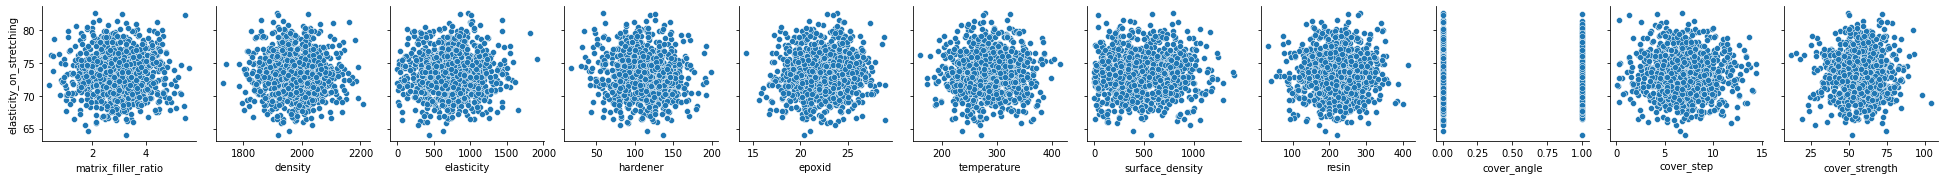

In [11]:
sns.pairplot(data=elasticity_on_stretch_data, x_vars=elasticity_on_stretch_data.columns[1:], y_vars=elasticity_on_stretch_data.columns[0]);

In [12]:
elasticity_on_stretch_data.corrwith(elasticity_on_stretch_data['elasticity_on_stretching'])

elasticity_on_stretching    1.000000
matrix_filler_ratio        -0.017502
density                    -0.020699
elasticity                  0.014482
hardener                   -0.076936
epoxid                      0.064757
temperature                 0.023145
surface_density             0.014983
resin                       0.045590
cover_angle                 0.020558
cover_step                 -0.031345
cover_strength              0.014858
dtype: float64

### Важно! 
### Полностью отсутствует линейная взаимосвязь признаков с целевой переменной (elastisity_onstretching = Модуль упругости при растяжении). Корреляция - околонулевая.
### Похоже, перспективы получить качественную модель регрессии крайне малы.

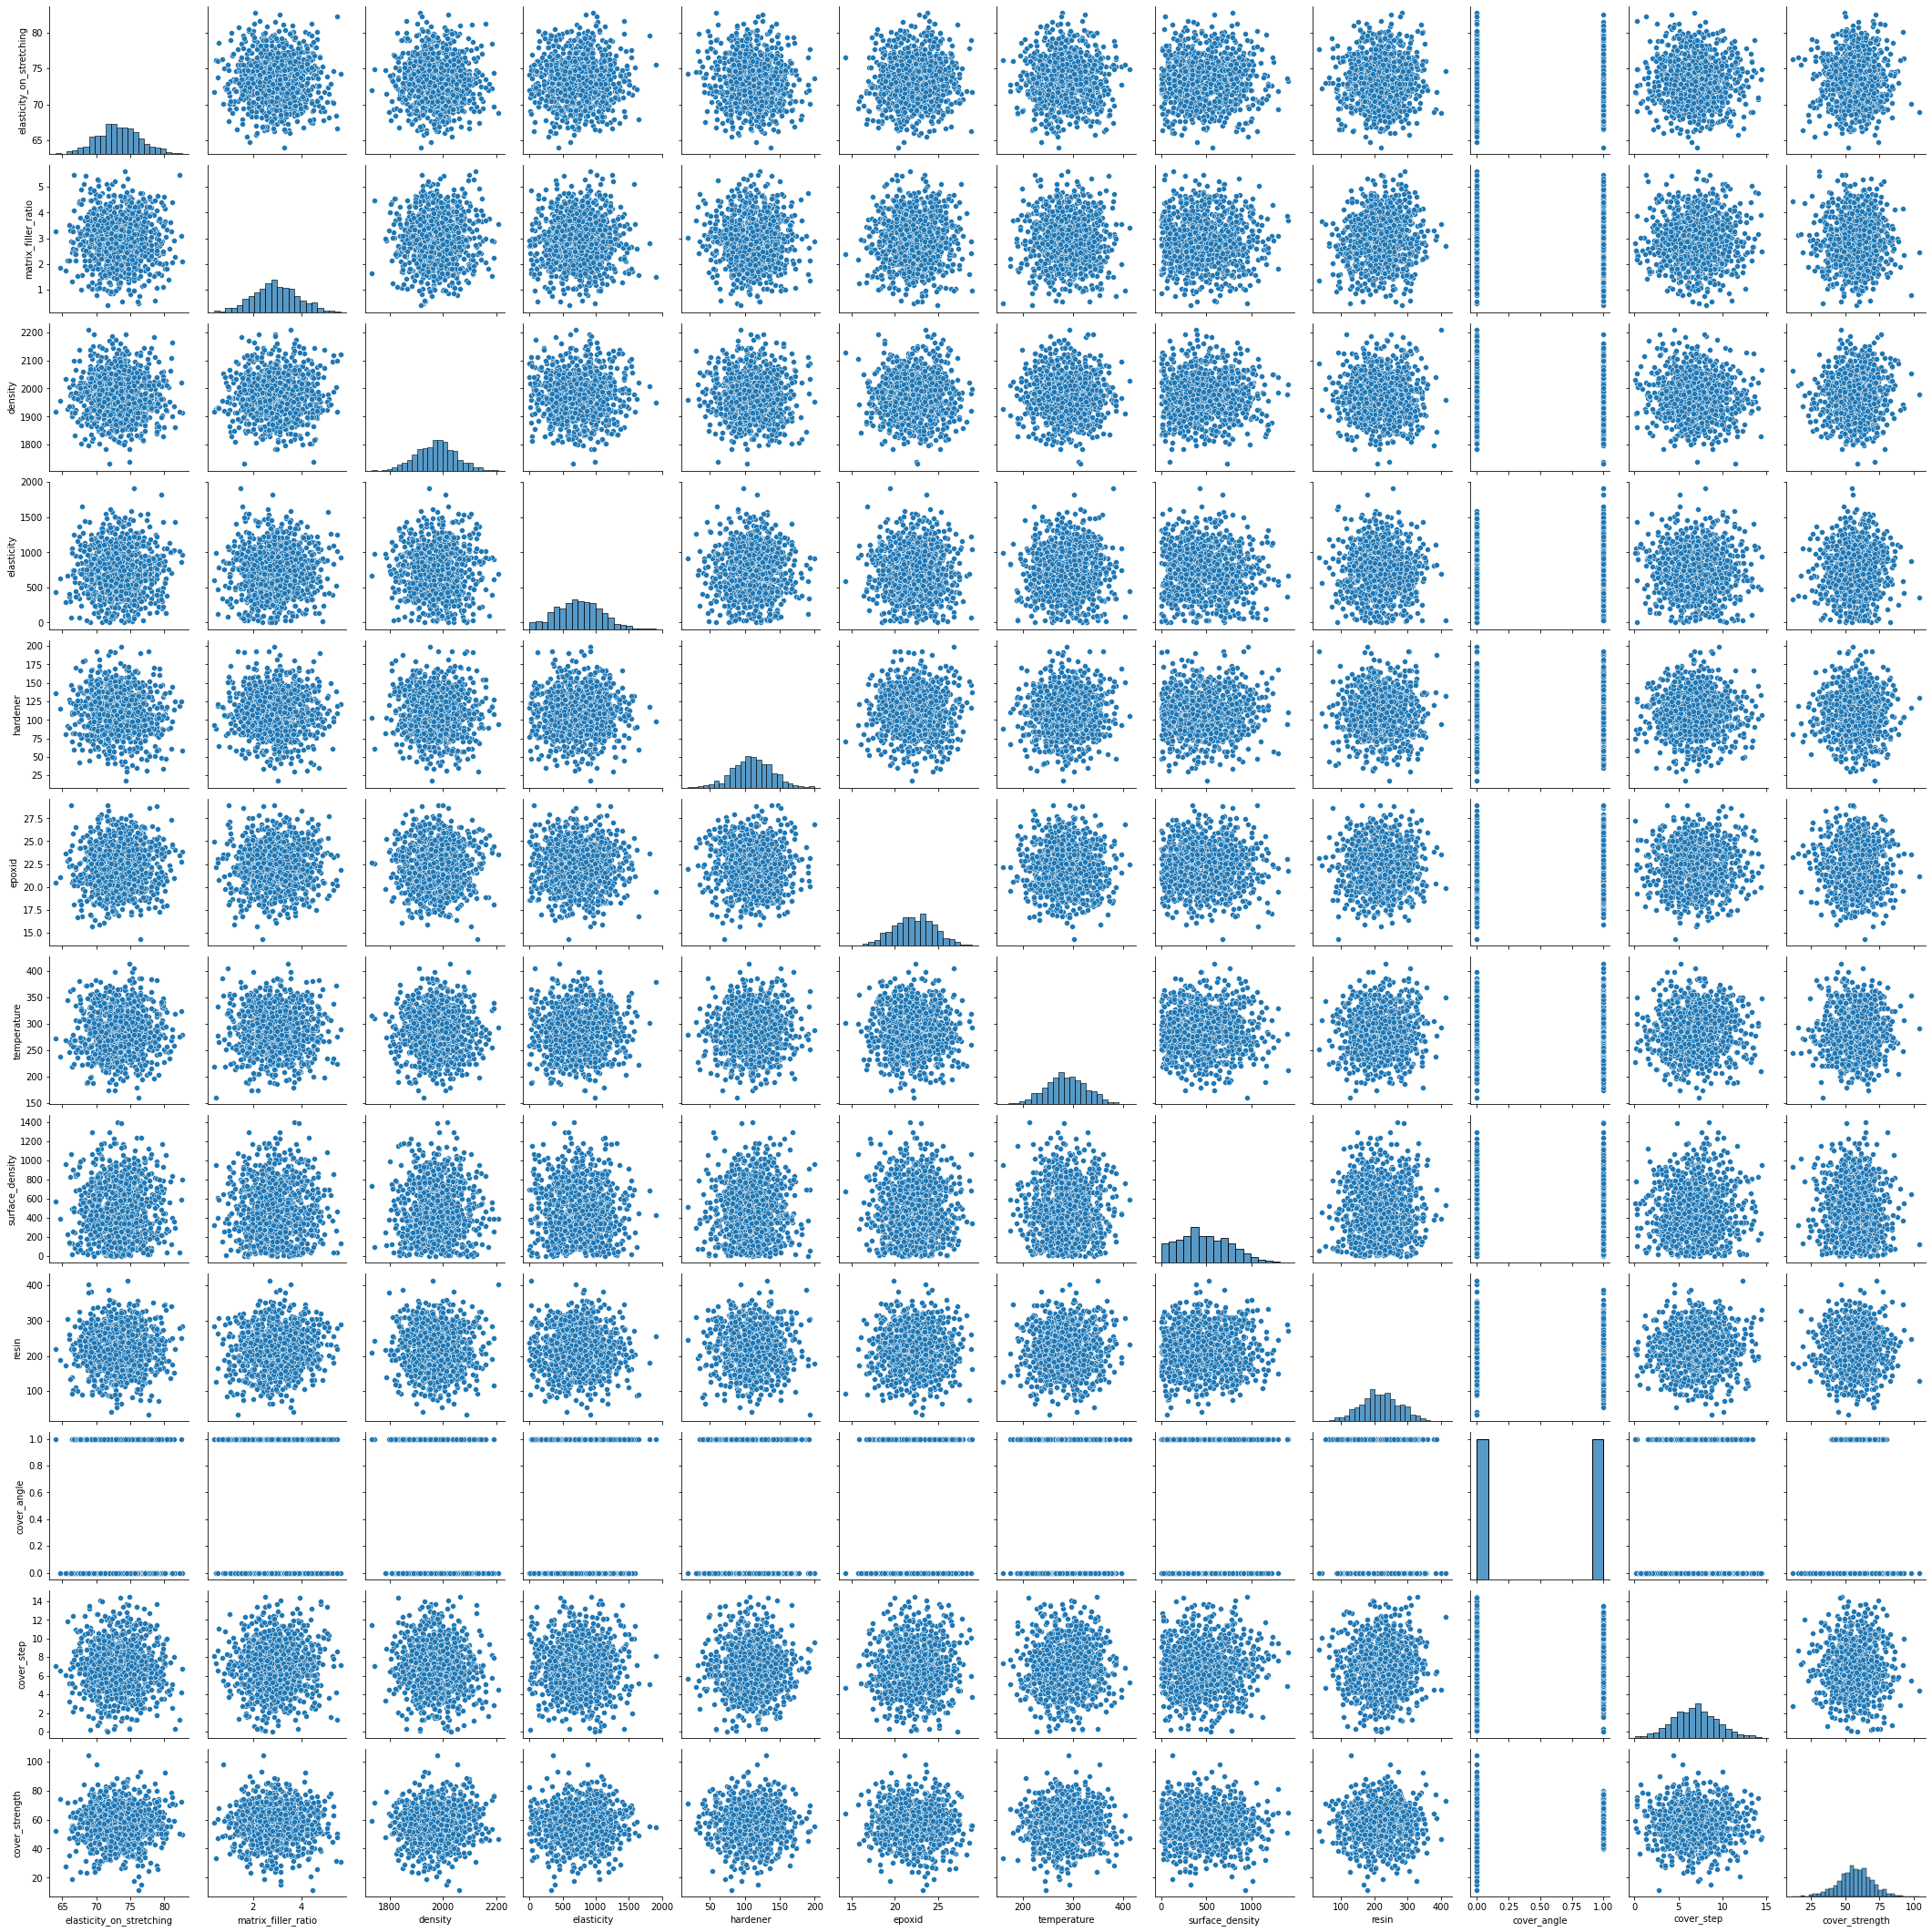

In [13]:
sns.pairplot(data=elasticity_on_stretch_data);

### Явные связи между признаками также отсутствуют.
### Перспективы получить какие-то новые признаки через feature engineering, видимо, тоже невелики. Но можно попробовать (а) парное перемножение признаков и (б) получить новые признаки через PCA (главне компоненты).   

### Далее про наблюдения и данные...
### Практически все признаки (то же касается и целевой переменной) имеют форму распределения очень близкую к нормальному, что хорошо.
### Но есть некоторые признаки, над которыми можно поработать для улучшения формы их распределения. 

For elasticity_on_stretching Shapiro-Wilk test says: normal
For matrix_filler_ratio Shapiro-Wilk test says: normal
For density Shapiro-Wilk test says: normal
For elasticity Shapiro-Wilk test says: not normal
For hardener Shapiro-Wilk test says: normal
For epoxid Shapiro-Wilk test says: normal
For temperature Shapiro-Wilk test says: normal
For surface_density Shapiro-Wilk test says: not normal
For resin Shapiro-Wilk test says: normal
For cover_step Shapiro-Wilk test says: normal
For cover_strength Shapiro-Wilk test says: not normal


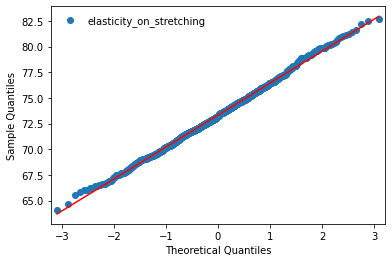

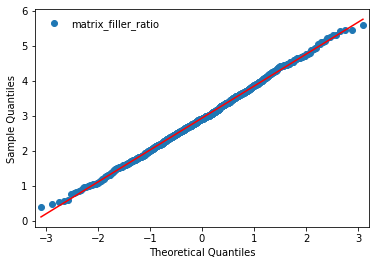

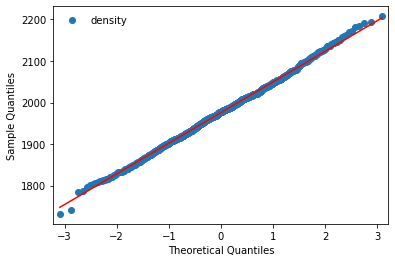

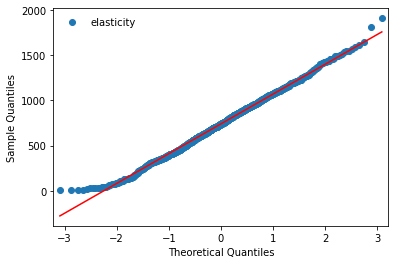

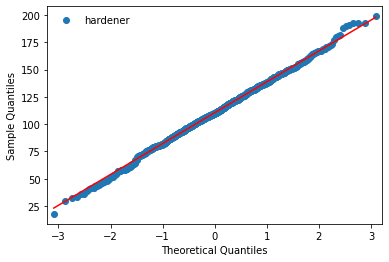

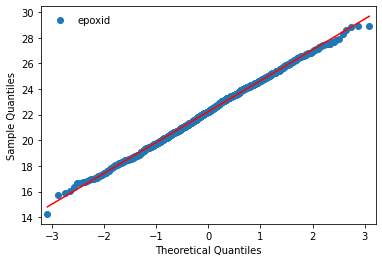

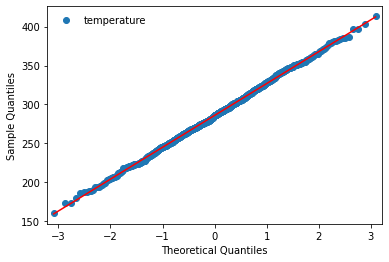

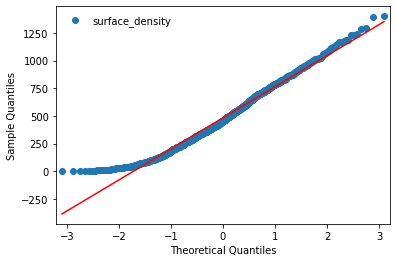

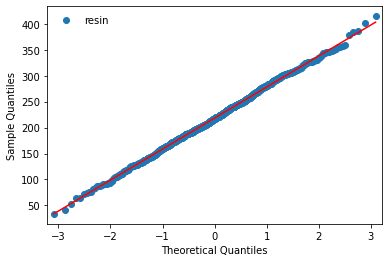

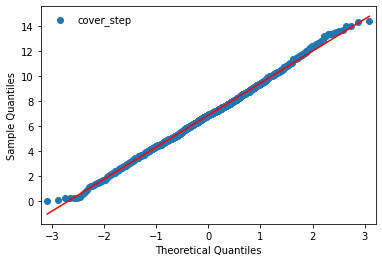

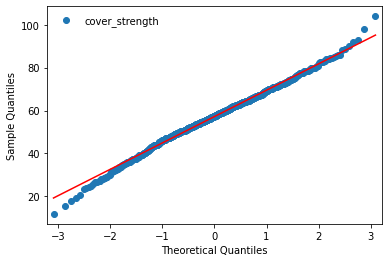

In [14]:
# Проверка на нормальность распределения
# Shapiro-Wilk says H0 hypothesis is that data is normally distributed

for variable_name in elasticity_on_stretch_data.columns.tolist():
    if variable_name != 'cover_angle':
        print(f'For {variable_name} Shapiro-Wilk test says: {"normal" if shapiro(elasticity_on_stretch_data[variable_name].values)[1] > 0.05 else "not normal"}')    
        sm.qqplot(elasticity_on_stretch_data[variable_name],  line='s', label=variable_name)
        plt.legend(frameon=False);

### Применяем boxcox трансформацию для признака 'elasticity' (модуль упругости)

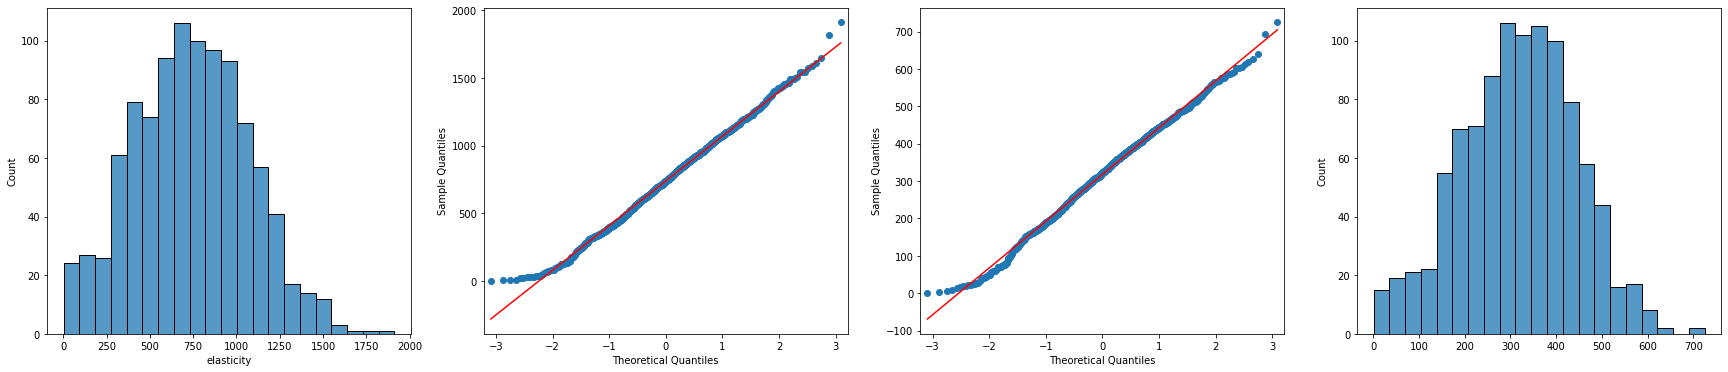

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
sns.histplot(elasticity_on_stretch_data['elasticity'], ax=ax[0])
sm.qqplot(elasticity_on_stretch_data['elasticity'], line='s', ax=ax[1])
sm.qqplot(boxcox(elasticity_on_stretch_data['elasticity'])[0], line='s', ax=ax[2])
sns.histplot(boxcox(elasticity_on_stretch_data['elasticity'])[0], ax=ax[3])
plt.show()

In [16]:
# Проверка на отсутствие негативных значений
elasticity_on_stretch_data['elasticity'].min() , boxcox(elasticity_on_stretch_data['elasticity'].values + 1)[0].min()

(2.4369087535075, 2.1857594002244976)

In [17]:
elasticity_on_stretch_data['elasticity_boxcox'], elasticity_boxcox_lambda = boxcox(elasticity_on_stretch_data['elasticity'].values + 1)

### Применяем boxcox трансформацию для признака 'surface density' (поверхностная плотность)

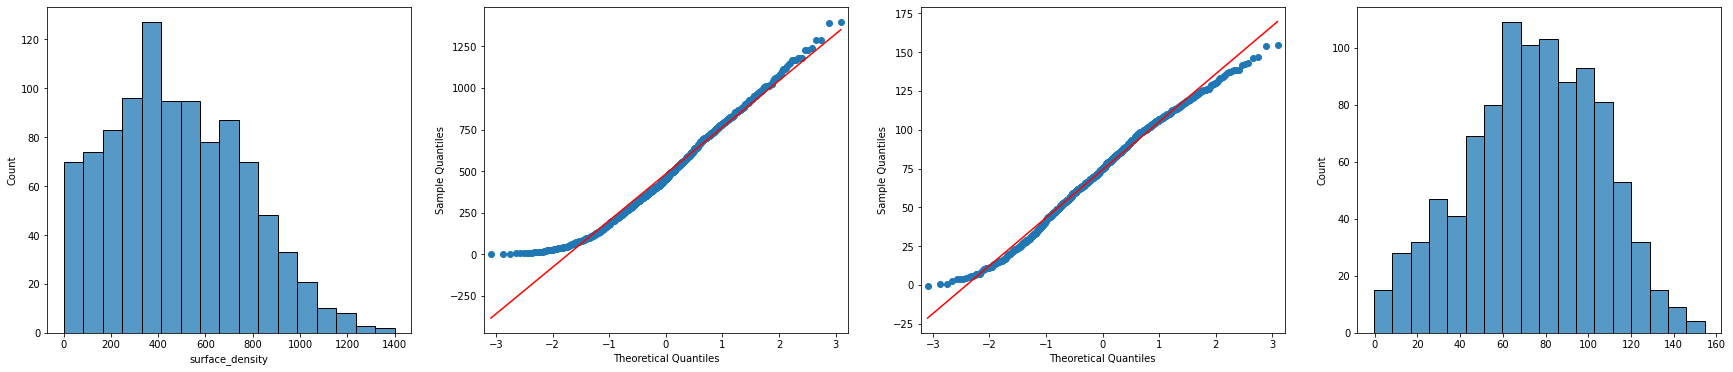

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
sns.histplot(elasticity_on_stretch_data['surface_density'], ax=ax[0])
sm.qqplot(elasticity_on_stretch_data['surface_density'], line='s', ax=ax[1])
sm.qqplot(boxcox(elasticity_on_stretch_data['surface_density'])[0], line='s', ax=ax[2])
sns.histplot(boxcox(elasticity_on_stretch_data['surface_density'])[0], ax=ax[3])
plt.show()

In [19]:
# Проверка на отсутствие негативных значений
elasticity_on_stretch_data['surface_density'].min() , boxcox(elasticity_on_stretch_data['surface_density'].values + 1)[0].min()

(0.603739925153945, 0.5508042842993189)

In [20]:
elasticity_on_stretch_data['surface_density_boxcox'], surface_density_boxcox_lambda = boxcox(elasticity_on_stretch_data['surface_density'].values + 1)

### Применяем boxcox трансформацию для признака 'cover strength' (плотность нашивки) 

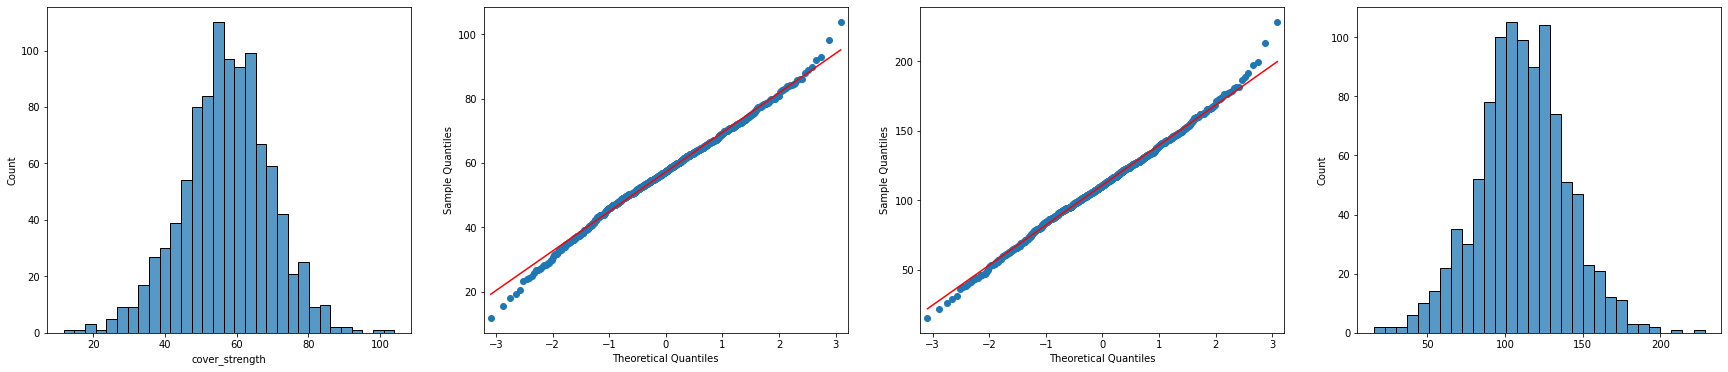

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
sns.histplot(elasticity_on_stretch_data['cover_strength'], ax=ax[0])
sm.qqplot(elasticity_on_stretch_data['cover_strength'], line='s', ax=ax[1])
sm.qqplot(boxcox(elasticity_on_stretch_data['cover_strength'] + 0.001)[0], line='s', ax=ax[2])
sns.histplot(boxcox(elasticity_on_stretch_data['cover_strength'] + 0.001)[0], ax=ax[3])
plt.show()

In [22]:
# Проверка на отсутствие негативных значений
elasticity_on_stretch_data['cover_strength'].min() , boxcox(elasticity_on_stretch_data['cover_strength'].values + 1)[0].min()

(11.7401256604075, 17.31381736884777)

In [23]:
elasticity_on_stretch_data['cover_strength_boxcox'], cover_strength_boxcox_lambda = boxcox(elasticity_on_stretch_data['cover_strength'].values + 1)

In [24]:
# Удаляем из датасета исходные значения признаков, которые трансформировали черех boxcox преобразование
elasticity_on_stretch_data = elasticity_on_stretch_data.drop(columns=['elasticity', 'surface_density', 'cover_strength'])
elasticity_on_stretch_data.head()

,elasticity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
0,80.803222,2.587348,1953.274926,137.627420,22.344534,234.716883,246.613117,1,4.0,468.670776,85.631671,145.526898
1,76.178075,2.499918,1942.595777,146.252208,23.081757,351.231874,226.222760,1,5.0,384.618053,113.823065,90.114645
2,73.817067,2.046471,2037.631811,101.617251,23.146393,312.307205,178.198556,1,5.0,312.793361,84.805005,113.632918
3,77.210762,1.856476,2018.220332,135.401697,26.435515,327.510377,123.344561,1,5.0,360.746332,36.659075,120.868161
4,72.345709,3.305535,1917.907506,105.786930,17.874100,328.154579,275.575880,1,5.0,223.892990,82.700017,145.526898


### Сохраняем значения BoxCox lambdas

In [25]:
elasticity_strech_data_lambdas = {
    'elasticity_boxcox_lambda': elasticity_boxcox_lambda,
    'surface_density_boxcox_lambda': surface_density_boxcox_lambda,
    'cover_strength_boxcox_lambda': cover_strength_boxcox_lambda}

elasticity_strech_data_lambdas

{'elasticity_boxcox_lambda': 0.8514864751506241,
 'surface_density_boxcox_lambda': 0.6348829215273967,
 'cover_strength_boxcox_lambda': 1.2154612257440889}

<AxesSubplot:>

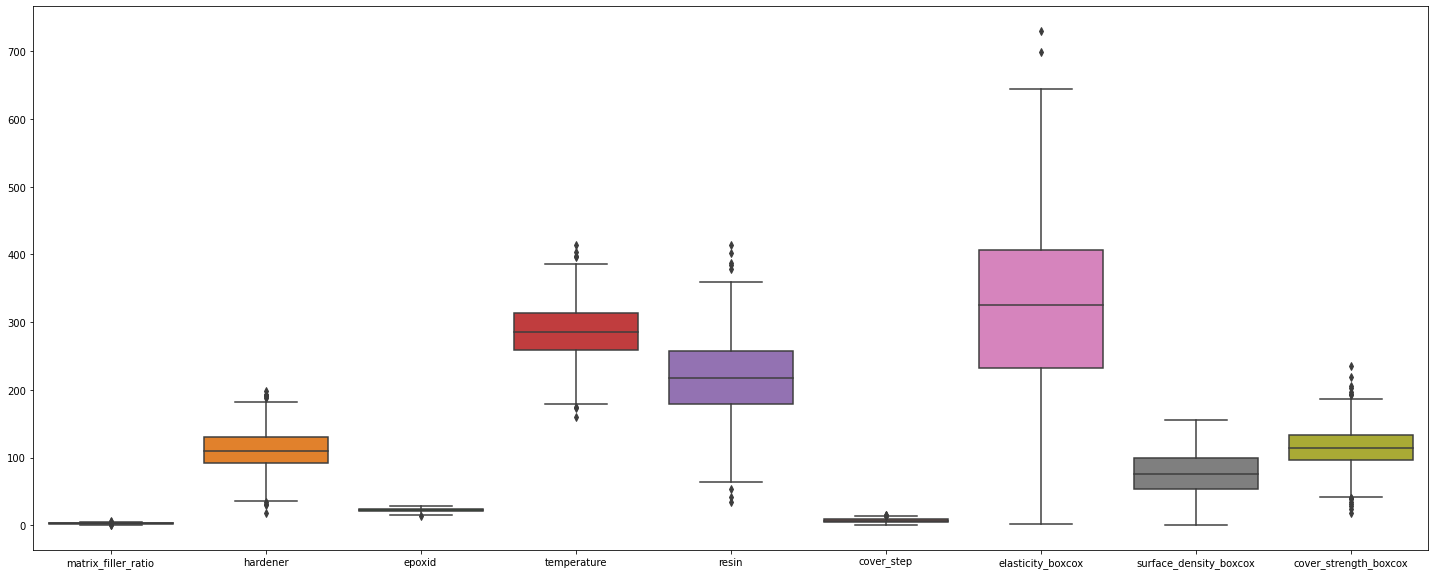

In [26]:
plt.figure(figsize=(25, 10))
sns.boxplot(elasticity_on_stretch_data.drop(columns=['elasticity_on_stretching', 'cover_angle', 'density']))

### В принципе, можно избавиться от выбросов

In [27]:
# Remove outliers

def compute_IQR_boundaries(data):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    IQR_bound_lower = data.quantile(0.25) - 1.5 * IQR
    IQR_bound_upper = data.quantile(0.75) + 1.5 * IQR
    return (IQR_bound_lower, IQR_bound_upper)


def detect_outliers(data):
    IQR = data.quantile(0.75) - data.quantile(0.25)
    IQR_bound_lower = data.quantile(0.25) - 1.5 * IQR
    IQR_bound_upper = data.quantile(0.75) + 1.5 * IQR
    res = [x if (x >= IQR_bound_lower) & (x <= IQR_bound_upper) else np.nan for x in data]
    return res

In [28]:
elasticity_on_stretch_data = pd.DataFrame(elasticity_on_stretch_data.apply(detect_outliers, axis=0)).dropna().reset_index(drop=True)
elasticity_on_stretch_data

,elasticity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
0,80.803222,2.587348,1953.274926,137.627420,22.344534,234.716883,246.613117,1,4.000000,468.670776,85.631671,145.526898
1,76.178075,2.499918,1942.595777,146.252208,23.081757,351.231874,226.222760,1,5.000000,384.618053,113.823065,90.114645
2,73.817067,2.046471,2037.631811,101.617251,23.146393,312.307205,178.198556,1,5.000000,312.793361,84.805005,113.632918
3,77.210762,1.856476,2018.220332,135.401697,26.435515,327.510377,123.344561,1,5.000000,360.746332,36.659075,120.868161
4,72.345709,3.305535,1917.907506,105.786930,17.874100,328.154579,275.575880,1,5.000000,223.892990,82.700017,145.526898
...,...,...,...,...,...,...,...,...,...,...,...,...
931,73.090961,2.271346,1952.087902,86.992183,20.123249,324.774576,125.007669,1,9.076380,388.740128,45.403985,90.160173
932,72.920827,3.444022,2050.089171,145.981978,19.599769,254.215401,117.730099,1,10.565614,210.404942,63.557294,105.887238
933,74.734344,3.280604,1972.372865,110.533477,23.957502,248.423047,236.606764,1,4.161154,199.076146,102.983095,139.609893
934,74.042708,3.705351,2066.799773,141.397963,19.246945,275.779840,197.126067,1,6.313201,325.540723,93.916114,116.664723


<AxesSubplot:>

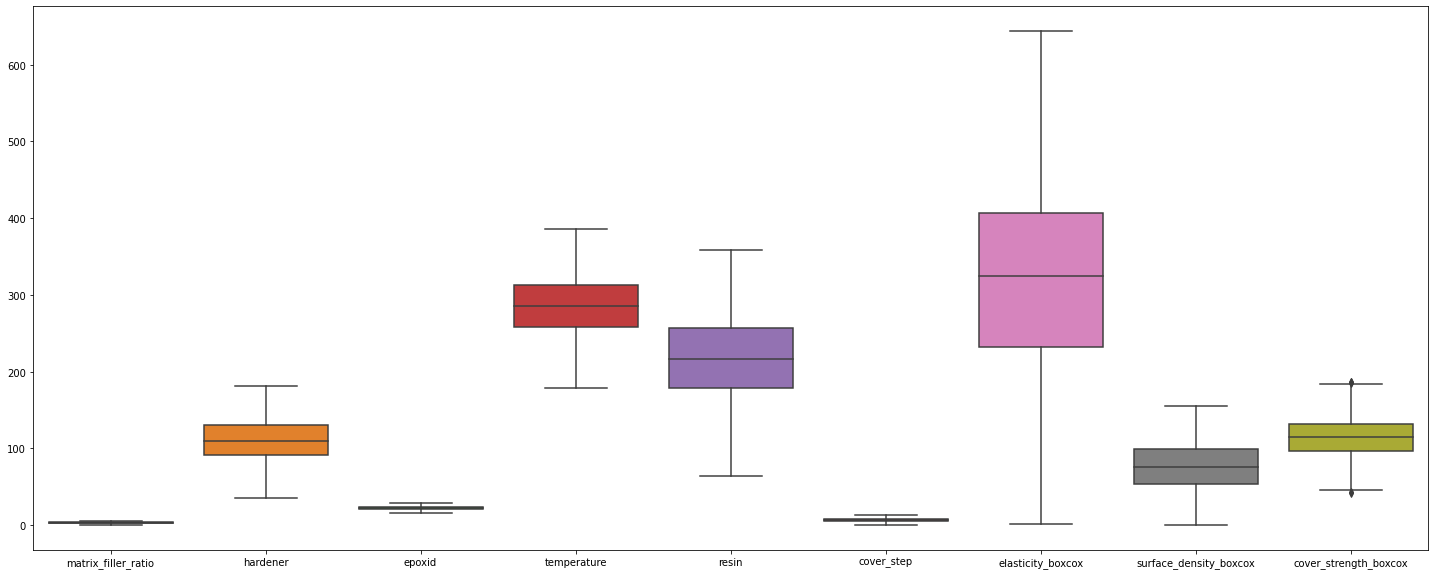

In [29]:
plt.figure(figsize=(25, 10))
sns.boxplot(elasticity_on_stretch_data.drop(columns=['elasticity_on_stretching', 'cover_angle', 'density']))

### Сохраняем финальный датасет для обучения моделей.

In [30]:
elasticity_on_stretch_data.to_csv('../data/data_for_model/elasticity_on_stretching_data_to_use.csv', sep=';', index=True)

# А что если ещё...

### Если нет линейной зависимости (отсутствует корреляция) между целевой переменной и признаками, взятыми по-отдельности / по-одному (т.е. по вертикали = feature-wise), то, возможно, целевая переменная "реагирует" на набор признаков, как единое целое, как "рецепт"/состав композитного материала, т.е. важная взаимосвязь признаков между собой по горизонтали - по строкам (sample-wise).   

### Тогда можно предположить, что относительно схожим значениям целевой переменной (т.е. разница д.б. близка к 0 или около того) должны соответствовать оносительтно схожие по своему составу ("рецепту") испытываемые образцы композитных материалов.

### Отсюда сделаем следующее упражнение... Попарно сравним все наблюдения (эксперименты) между собой на предмет схожести / разности через косинусное расстояние между векторами признаков и при этом будет фиксировать разницу между значениями целевой переменной сравниваемых векторов (= "рецептуры" композитных материалов). 

In [31]:
elasticity_on_stretch_data = pd.read_csv('../data/data_for_model/elasticity_on_stretching_data_to_use.csv', sep=';', index_col=[0])

In [32]:
# Убираем категориальную переменную (она просто даёт би-модальное распределение) и нормализуем данные.
cover_angle = elasticity_on_stretch_data.pop('cover_angle')
data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(elasticity_on_stretch_data), index=elasticity_on_stretch_data.index, columns=elasticity_on_stretch_data.columns)
# data_scaled = pd.concat([data_scaled, cover_angle], axis=1)
data_scaled

,elasticity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
0,0.961302,0.427955,0.447627,0.697727,0.501436,0.267751,0.619323,0.289334,0.727020,0.550721,0.716005
1,0.669748,0.409614,0.419307,0.756708,0.557037,0.831460,0.550289,0.362355,0.596024,0.733201,0.332551
2,0.520918,0.314487,0.671337,0.451468,0.561912,0.643139,0.387697,0.362355,0.484084,0.545370,0.495298
3,0.734845,0.274628,0.619859,0.682506,0.809975,0.716694,0.201982,0.362355,0.558819,0.233725,0.545366
4,0.428168,0.578621,0.353835,0.479982,0.164279,0.719810,0.717380,0.362355,0.345532,0.531744,0.716005
...,...,...,...,...,...,...,...,...,...,...,...
931,0.475147,0.361662,0.444480,0.351453,0.333908,0.703458,0.207613,0.660014,0.602448,0.290330,0.332866
932,0.464422,0.607674,0.704373,0.754860,0.294428,0.362087,0.182974,0.768759,0.324511,0.407835,0.441698
933,0.578740,0.573391,0.498274,0.512442,0.623085,0.334063,0.585446,0.301102,0.306855,0.663035,0.675059
934,0.535142,0.662497,0.748688,0.723512,0.267818,0.466417,0.451779,0.458245,0.503951,0.604345,0.516278


In [33]:
similarity_res = []
used_rows = []

for i in data_scaled.index.tolist():
    used_rows.append(i)
    target_master = data_scaled.loc[i, data_scaled.columns.tolist()[0]] 
    array_master = np.expand_dims(data_scaled.loc[i, data_scaled.columns.tolist()[1:]].values, axis=0)
    subset = data_scaled.drop(index=i)
    for j in subset.index.tolist():
        if j not in used_rows:
            target_pair = subset.loc[j, subset.columns.tolist()[0]]
            array_pair = np.expand_dims(subset.loc[j, subset.columns.tolist()[1:]].values, axis=0)
            # target_diff = np.abs(target_master - target_pair)
            target_diff = target_master - target_pair
            cosin_sim = cosine_similarity(array_master, array_pair).ravel()[0]
            similarity_res.append((target_diff, cosin_sim))

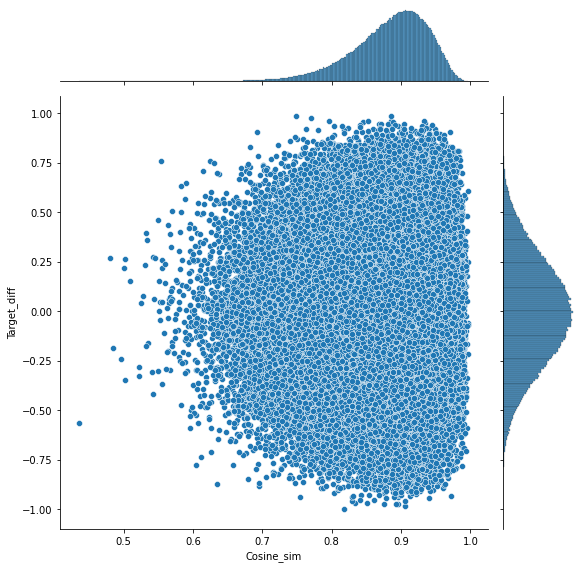

In [34]:
similarity_df = pd.DataFrame(similarity_res, columns=['Target_diff', 'Cosine_sim'])
sns.jointplot(data=similarity_df, x='Cosine_sim', y='Target_diff', height=8)

In [35]:
np.corrcoef(similarity_df['Cosine_sim'], similarity_df['Target_diff'])[0][1]

-0.00227733538645236

### Получается странная картина... чем менее схожи попарно между собой эксперименты по "рецептуре" (т.е. меньше косинусное расстояние), тем меньше разница в целевых переменных и наоборот - чем выше сходство (косинусное расстояние ближе к 1), тем больше разница между получаемыми значениями целевой переменной. 

### Вывод: 
### Классическая регрессия, скорее всего, не сработает, в т.ч. разбиение на train-test. Возможно, более правильным (но в тоже время - ресурсоёмким) решением будет сравнение моделей через LeaveOneOut кросс-валидацию.
### Другой вариант - от задачи регресии перейти к задаче классификации, разбив целевую переменную на интервалы (bins) = классы, и каждый класс будет соответствовать среднему значению целевой переменной в заданном интервале.

In [36]:
# def assign_hist_bin_number(data, n_bins=10):
#     _, binEdges = np.histogram(data, bins=n_bins)
#     bin_numbers = [[i + 1  for i in np.arange(n_bins) if (x >= binEdges[i]) & (x <= binEdges[i + 1])] for x in data]
#     return bin_numbers

In [37]:
# bins = pd.DataFrame(data_elasticity.drop(columns=['cover_angle']).apply(assign_hist_bin_number, axis=0)).dropna().reset_index(drop=True).apply(lambda x: sum(x, []), axis=1).to_frame()
# bins = pd.DataFrame(data_elasticity.drop(columns=['cover_angle']).apply(assign_hist_bin_number, axis=0)).apply(lambda x: sum(x, []), axis=1).to_frame()
# bins_df = bins[0].apply(pd.Series)
# bins_df.columns = data_elasticity.drop(columns=['cover_angle']).columns
# bins_df

In [38]:
# bins_df.isna().sum()

In [39]:
# y_bin_labels = bins_df['elasticity_on_stretching'].unique().astype(int)
# y_bins_matched = {}
# y_bins_missmatched = {}

# for y_label in y_bin_labels:    
#     subset = bins_df.loc[bins_df['elasticity_on_stretching'] == y_label, bins_df.columns[1:]]    
#     for idx in subset.index:
#         row_main = subset.loc[idx, :].values
#         subset_2 = subset.drop(index=[idx])
#         for idx_2 in subset_2.index:
#             row_compare = subset_2.loc[idx_2, :].values
#             if np.sum(np.abs(np.subtract(row_main, row_compare))) == 0:
#                 y_bins_matched.setdefault(y_label, []).append((idx, idx_2))
#             else:
#                 y_bins_missmatched.setdefault(y_label, []).append((idx, idx_2))

In [40]:
# all_y_bins_matched = []
# all_y_bins_missmatched = []

# for idx in bins_df.index:
#     row_main = bins_df.loc[idx, :].values
#     subset = bins_df.drop(index=[idx])
#     for idx_2 in subset.index:
#         row_compare = subset.loc[idx_2, :].values
#         if np.sum(np.abs(np.subtract(row_main, row_compare))) == 0:
#             all_y_bins_matched.append((idx, idx_2))
#         else:
#             all_y_bins_missmatched.append((idx, idx_2))

In [41]:
# y_bins_matched

In [42]:
# y_bins_missmatched